## Desafio 4 : Traductor seq2seq

---
### 1. Librerias

In [1]:
import os
import re
import sys
import math
import pickle
import numpy as np
import pandas as pd
import logging
from pathlib import Path
from io import StringIO
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Tuple, List, Dict
import gdown
import copy

from sklearn.model_selection import train_test_split

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

# Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2025-12-06 15:51:06.740388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 15:51:06.774542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 15:51:07.532234: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow Version: 2.20.0
GPU Available: True


---
### 2. Clase de configuracion
Uso una dataclass para gestionar los hiperparametros y testear mejor los escenarios

In [2]:
class Config:
    def __init__(self):
        # Datos
        self.MAX_NUM_SENTENCES = 6000  # Original: 6000
        self.MAX_VOCAB_SIZE = 8000     # Original: 8000
        
        # Arquitectura 
        self.MAX_INPUT_LEN = 30        # Original: 16
        self.MAX_OUT_LEN = 32          # Original: 18
        self.LSTM_UNITS = 128          # Original: 128
        self.EMBEDDING_DIM = 50        # GloVe 50d
        self.DROPOUT_RATE = 0.2         # Original: 0.2
        
        # Entrenamiento
        self.BATCH_SIZE = 32           
        self.EPOCHS = 15               # Original: 15
        self.VAL_SPLIT = 0.2           # Original: 0.2
        self.EARLY_STOPPING_PATIENCE = 3   # Cuántas épocas esperar sin mejora
        self.EARLY_STOPPING_MONITOR = 'val_loss' 
        self.MIN_DELTA = 0.001             # Mínima mejora requerida
        
        # Rutas
        self.DATA_FILE = "./spa-eng/spa.txt"
        self.GLOVE_PKL = 'gloveembedding.pkl'

cfg = Config()
np.random.seed([40]) # Semilla original

In [3]:
def estimate_memory_usage(config):
    # 1. Parámetros
    n_samples = config.MAX_NUM_SENTENCES
    n_vocab_in = config.MAX_VOCAB_SIZE
    n_vocab_out = config.MAX_VOCAB_SIZE # Asumimos peor caso: vocab lleno
    len_in = config.MAX_INPUT_LEN
    len_out = config.MAX_OUT_LEN
    
    print(f"Configuración:")
    print(f" - Samples: {n_samples}")
    print(f" - Vocab Size: {n_vocab_out}")
    print(f" - Seq Lengths: {len_in} (in) / {len_out} (out)")
    
    # Encoder Input: (Samples, Len_in) de enteros (4 bytes)
    bytes_enc = n_samples * len_in * 4
    
    # Decoder Input: (Samples, Len_out) de enteros (4 bytes)
    bytes_dec_in = n_samples * len_out * 4
    
    # Decoder Target: (Samples, Len_out, Vocab) de floats (4 bytes) 
    # Esta es la matriz One-Hot densa que usa 'to_categorical'
    elements_dec_out = n_samples * len_out * n_vocab_out
    bytes_dec_out = elements_dec_out * 4
    
    # 3. Conversión a GB
    gb_enc = bytes_enc / (1024**3)
    gb_dec_in = bytes_dec_in / (1024**3)
    gb_dec_out = bytes_dec_out / (1024**3)
    
    total_gb = gb_enc + gb_dec_in + gb_dec_out
    
    # 4. Reporte
    print(f"\nUso Estimado de RAM:")
    print(f" - Encoder Input: {gb_enc:.4f} GB")
    print(f" - Decoder Input: {gb_dec_in:.4f} GB")
    print(f" - Decoder Target (One-Hot): {gb_dec_out:.4f} GB  <-- CRÍTICO")
    print(f"{'-'*30}")
    print(f" TOTAL ESTIMADO: {total_gb:.2f} GB")
    

    limit_safe = 24.0 
    
    if total_gb > limit_safe:
        print(f"\n[WARNING] El uso estimado de RAM excede el límite seguro de {limit_safe} GB.")
        return False
    else:
        print(f"\n[OK]")
        return True

---
### 3. Dataset Handling

In [4]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            pass 
        
        if words_embedding_pkl.is_file():
            self.embeddings = self.load_model_from_pickle()
            index = np.arange(self.embeddings.shape[0])
            self.word2idx = dict(zip(self.embeddings['word'], index))
            self.idx2word = dict(zip(index, self.embeddings['word']))
            self.N_FEATURES = self.embeddings['embedding'].shape[1] # Detectar dim dinamicamente si es posible
        else:
            print(f"Advertencia: No se encontró {self.PKL_PATH}. Se usará matriz de ceros temporalmente o fallará.")

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        return embeddings

class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

def download_glove_if_needed(pkl_path):
    import gdown
    if not os.path.exists(pkl_path):
        print("Descargando embeddings...")
        url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
        gdown.download(url, pkl_path, quiet=False)
    else:
        print("Embeddings ya descargados.")

In [5]:
class TranslationGenerator(tf.keras.utils.Sequence):
    def __init__(self, encoder_input, decoder_input, decoder_output_seq, batch_size, vocab_size, shuffle=True):
        """
        :param encoder_input: Array numpy con secuencias de entrada (padded integers)
        :param decoder_input: Array numpy con secuencias de entrada al decoder (padded integers)
        :param decoder_output_seq: Array numpy con secuencias de salida (padded integers - NO OneHot)
        :param batch_size: Tamaño del lote
        :param vocab_size: Tamaño del vocabulario de salida (para el One-Hot)
        """
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.decoder_output_seq = decoder_output_seq
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.encoder_input))

    def __len__(self):
        # Número de batches por época
        return math.ceil(len(self.encoder_input) / self.batch_size)

    def __getitem__(self, idx):
        # Índices para este batch
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.encoder_input))
        batch_indices = self.indices[start:end]

        # Obtener los datos del batch
        batch_enc = self.encoder_input[batch_indices]
        batch_dec_in = self.decoder_input[batch_indices]
        batch_dec_out_int = self.decoder_output_seq[batch_indices]

        batch_dec_target = to_categorical(batch_dec_out_int, num_classes=self.vocab_size)

        return (batch_enc, batch_dec_in), batch_dec_target

    def on_epoch_end(self):
        # Mezclar índices al final de cada época para mejor entrenamiento
        if self.shuffle:
            np.random.shuffle(self.indices)

In [6]:
class DatasetHandler:
    def __init__(self, config):
        self.cfg = config
        self.input_tokenizer = None
        self.output_tokenizer = None
        
    def prepare_data(self):
        # 1. Descarga (Igual que antes)
        if not os.path.exists('spa-eng') and not os.path.exists('spa-eng.zip'):
            os.system("curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'")
            os.system("unzip -q spa-eng.zip")

        # 2. Lectura
        with open(self.cfg.DATA_FILE) as f:
            lines = f.read().split("\n")[:-1]
        
        if self.cfg.MAX_NUM_SENTENCES < len(lines):
            lines = lines[:self.cfg.MAX_NUM_SENTENCES]
            
        input_sentences = []
        output_sentences = []
        output_sentences_inputs = []

        for line in lines:
            if '\t' not in line: continue
            input_sentence, output = line.rstrip().split('\t')
            output_sentence = output + ' <eos>'
            output_sentence_input = '<sos> ' + output

            input_sentences.append(input_sentence)
            output_sentences.append(output_sentence)
            output_sentences_inputs.append(output_sentence_input)

        # 3. Tokenización
        self.input_tokenizer = Tokenizer(num_words=self.cfg.MAX_VOCAB_SIZE)
        self.input_tokenizer.fit_on_texts(input_sentences)
        input_integer_seq = self.input_tokenizer.texts_to_sequences(input_sentences)
        
        self.output_tokenizer = Tokenizer(num_words=self.cfg.MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
        self.output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
        output_integer_seq = self.output_tokenizer.texts_to_sequences(output_sentences)
        output_input_integer_seq = self.output_tokenizer.texts_to_sequences(output_sentences_inputs)

        # 4. Cálculo de Dimensiones Reales 
        encoder_input_sequences = pad_sequences(input_integer_seq, padding='pre')
        decoder_input_sequences = pad_sequences(output_input_integer_seq, padding='post')
        decoder_output_sequences = pad_sequences(output_integer_seq, padding='post')
        
        self.cfg.MAX_INPUT_LEN = encoder_input_sequences.shape[1]
        self.cfg.MAX_OUT_LEN = decoder_input_sequences.shape[1]
        
        print(f"--> Secuencias ajustadas: InLen={self.cfg.MAX_INPUT_LEN}, OutLen={self.cfg.MAX_OUT_LEN}")
        
        # Estadísticas de vocabulario
        word2idx_inputs = self.input_tokenizer.word_index
        word2idx_outputs = self.output_tokenizer.word_index
        num_words_output = min(len(word2idx_outputs) + 1, self.cfg.MAX_VOCAB_SIZE)
        nb_words_input = min(self.cfg.MAX_VOCAB_SIZE, len(word2idx_inputs))
        
        # Split Train / Validation Manual
        idx_train, idx_val = train_test_split(
            np.arange(len(decoder_input_sequences)), 
            test_size=self.cfg.VAL_SPLIT, 
            random_state=42
        )
        
        train_gen = TranslationGenerator(
            encoder_input=encoder_input_sequences[idx_train],
            decoder_input=decoder_input_sequences[idx_train],
            decoder_output_seq=decoder_output_sequences[idx_train],
            batch_size=self.cfg.BATCH_SIZE,
            vocab_size=num_words_output,
            shuffle=False
        )
        
        val_gen = TranslationGenerator(
            encoder_input=encoder_input_sequences[idx_val],
            decoder_input=decoder_input_sequences[idx_val],
            decoder_output_seq=decoder_output_sequences[idx_val],
            batch_size=self.cfg.BATCH_SIZE,
            vocab_size=num_words_output,
            shuffle=False
        )
        
        return {
            'train_gen': train_gen,
            'val_gen': val_gen,
            'nb_words_input': nb_words_input,
            'num_words_output': num_words_output,
            'word2idx_inputs': word2idx_inputs,
            'word2idx_outputs': word2idx_outputs,
            'sample_input_data': encoder_input_sequences[idx_val] 
        }
        
        

        # Targets one-hot
        # Aseguramos que el target tenga el mismo largo que el input del decoder
        # decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=self.cfg.MAX_OUT_LEN, padding='post')
        # decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

        # return {
        #     'encoder_input': encoder_input_sequences,
        #     'decoder_input': decoder_input_sequences,
        #     'decoder_target': decoder_targets,
        #     'nb_words_input': nb_words_input,
        #     'num_words_output': num_words_output,
        #     'word2idx_inputs': word2idx_inputs,
        #     'word2idx_outputs': word2idx_outputs
        # }

    def create_embedding_matrix(self, model_embeddings, nb_words, word2idx):
        embed_dim = model_embeddings.N_FEATURES
        embedding_matrix = np.zeros((nb_words, embed_dim))
        for word, i in word2idx.items():
            if i >= nb_words:
                continue
            try:
                embedding_vector = model_embeddings.get_words_embeddings([word])[0]
                if (embedding_vector is not None) and len(embedding_vector) > 0:
                    embedding_matrix[i] = embedding_vector
            except:
                pass 
        return embedding_matrix

---
## 5. Arquitectura del modelo

Armo un model factory para poder probar rapidamente varios tipos de celdas y tama~nos

In [7]:
class ModelFactory:
    def __init__(self, config, embed_dim, embedding_matrix, nb_words_input, num_words_output):
        self.cfg = config
        self.embedding_matrix = embedding_matrix
        self.embed_dim = embed_dim
        self.nb_words_input = nb_words_input
        self.num_words_output = num_words_output
        
        # Referencias a las 3 partes del modelo 
        self.train_model = None
        self.encoder_model = None
        self.decoder_model = None

    def build(self):
        n_units = self.cfg.LSTM_UNITS
        # Definimos una tasa de dropout (si no está en config, usa 0.2 por defecto)
        dropout_rate = getattr(self.cfg, 'DROPOUT_RATE', 0.2)
        
        # --- 1. Encoder - entrenamiento ---
        encoder_inputs = Input(shape=(self.cfg.MAX_INPUT_LEN,), name='enc_input')
        
        encoder_embedding_layer = Embedding(
            input_dim=self.nb_words_input,
            output_dim=self.embed_dim,
            input_length=self.cfg.MAX_INPUT_LEN,
            weights=[self.embedding_matrix],
            trainable=False, name='enc_embedding')
            
        encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
        
        encoder_inputs_x = Dropout(dropout_rate, name='enc_dropout')(encoder_inputs_x)
        
        encoder_lstm = LSTM(n_units, return_state=True, name='enc_lstm', dropout=dropout_rate)
        encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs_x)
        encoder_states = [state_h, state_c]
        
        # --- 2. Decoder - entrenamiento ---
        decoder_inputs = Input(shape=(self.cfg.MAX_OUT_LEN,), name='dec_input')
        
        decoder_embedding_layer = Embedding(
            input_dim=self.num_words_output, 
            output_dim=n_units, 
            input_length=self.cfg.MAX_OUT_LEN, name='dec_embedding')
            
        decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
        
        decoder_inputs_x = Dropout(dropout_rate, name='dec_dropout')(decoder_inputs_x)
        
        decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, name='dec_lstm', dropout=dropout_rate)
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
        
        decoder_dense = Dense(self.num_words_output, activation='softmax', name='dec_dense')
        decoder_outputs = decoder_dense(decoder_outputs)
        
        self.train_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        self.train_model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

        
        # Encoder Inference
        self.encoder_model = Model(encoder_inputs, encoder_states)
        
        # Decoder Inference
        decoder_state_input_h = Input(shape=(n_units,))
        decoder_state_input_c = Input(shape=(n_units,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        
        decoder_inputs_single = Input(shape=(1,))
        decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single) 
        
        # Reutilizamos la misma capa LSTM 
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs) 
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        
        self.decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)
        
        return self.train_model

---
### 6. Inferencia clase 

In [8]:
class InferenceEngine:
    def __init__(self, encoder_model, decoder_model, word2idx_outputs, config):
        self.encoder_model = encoder_model
        self.decoder_model = decoder_model
        self.word2idx_outputs = word2idx_outputs
        self.cfg = config
        
        # Invertir diccionarios
        self.idx2word_target = {v:k for k, v in word2idx_outputs.items()}
        self.eos_token = word2idx_outputs['<eos>']
        self.sos_token = word2idx_outputs['<sos>']

    def translate_sentence(self, input_seq):
        
        states_value = self.encoder_model.predict(input_seq, verbose=0)
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.sos_token
        
        output_sentence = []
        for _ in range(self.cfg.MAX_OUT_LEN):
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value, verbose=0)
            idx = np.argmax(output_tokens[0, 0, :])
            
            if self.eos_token == idx:
                break
            
            if idx > 0:
                word = self.idx2word_target[idx]
                output_sentence.append(word)
                
            states_value = [h, c]
            target_seq[0, 0] = idx
            
        return ' '.join(output_sentence)

---
## 7. Trainning class

In [9]:
class PerplexityCallback(Callback):
    """
    Callback para calcular y mostrar la Perplejidad (Perplexity) al final de cada epoch.
    Perplexity ~ exp(CrossEntropyLoss)
    """
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Calculamos perplejidad de entrenamiento
        loss = logs.get('loss')
        if loss:
            perplexity = np.exp(loss)
            logs['perplexity'] = perplexity # Lo guardamos en logs para graficar si queremos
            print(f" - perplexity: {perplexity:.4f}", end='')
        
        # Calculamos perplejidad de validación
        val_loss = logs.get('val_loss')
        if val_loss:
            val_perplexity = np.exp(val_loss)
            logs['val_perplexity'] = val_perplexity
            print(f" - val_perplexity: {val_perplexity:.4f}", end='')

class Trainer:
    def __init__(self, model, data, config):
        """
        :param model: Modelo de Keras compilado (ModelFactory.train_model)
        :param data: Diccionario con datos ('encoder_input', 'decoder_target', etc)
        :param config: Objeto Config
        """
        self.model = model
        self.data = data
        self.cfg = config
        self.callbacks = []
        self.history = None

    def _setup_callbacks(self, use_early_stopping=True, use_perplexity=True, checkpoint_path=None):
        self.callbacks = []
        
        # 1. Perplexity 
        # if use_perplexity:
        #     self.callbacks.append(PerplexityCallback())

        # 2. Early Stopping
        if use_early_stopping:
            es = EarlyStopping(
                monitor=self.cfg.EARLY_STOPPING_MONITOR,
                patience=self.cfg.EARLY_STOPPING_PATIENCE,
                min_delta=self.cfg.MIN_DELTA,
                restore_best_weights=True,
                mode='min',
                verbose=1
            )
            self.callbacks.append(es)
            
        # 3. Model Checkpoint (Opcional, guarda los pesos del mejor modelo)
        if checkpoint_path:
            mc = ModelCheckpoint(
                filepath=checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,
                verbose=0,
                mode='min'
            )
            self.callbacks.append(mc)

    def train(self):
        self._setup_callbacks()
        
        print(f"Iniciando entrenamiento con Generadores...")
        
        if 'train_gen' in self.data:
            self.history = self.model.fit(
                self.data['train_gen'],
                validation_data=self.data['val_gen'],
                epochs=self.cfg.EPOCHS,
                callbacks=self.callbacks,
                verbose=1
            )
        else:
            self.history = self.model.fit(
                [self.data['encoder_input'], self.data['decoder_input']],
                self.data['decoder_target'],
                epochs=self.cfg.EPOCHS,
                batch_size=self.cfg.BATCH_SIZE,
                validation_split=self.cfg.VAL_SPLIT,
                callbacks=self.callbacks,
                verbose=1 
            )
        return self.history

    def plot_metrics(self):
        """Grafica Loss, Accuracy y Perplexity si está disponible"""
        if not self.history:
            print("El modelo no ha sido entrenado aún.")
            return

        history = self.history.history
        epochs = range(1, len(history['loss']) + 1)
        
        # Detectar si tenemos perplejidad
        cols = 3 if 'perplexity' in history else 2
        plt.figure(figsize=(6 * cols, 5))

        # Plot Loss
        plt.subplot(1, cols, 1)
        plt.plot(epochs, history['loss'], label='Train Loss')
        plt.plot(epochs, history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        # Plot Accuracy
        plt.subplot(1, cols, 2)
        plt.plot(epochs, history['accuracy'], label='Train Acc')
        plt.plot(epochs, history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        # Plot Perplexity
        if 'perplexity' in history:
            plt.subplot(1, cols, 3)
            plt.plot(epochs, history['perplexity'], label='Train Ppl')
            plt.plot(epochs, history['val_perplexity'], label='Val Ppl')
            plt.title('Perplexity (Lower is better)')
            plt.legend()
            plt.grid(True)
            
        plt.tight_layout()
        plt.show()

---
## Pruebas

In [10]:
def run_experiment(name, config_overrides, glove_embeddings):

    # 1. Clonar y actualizar configuración
    current_cfg = Config() 
    for key, value in config_overrides.items():
        if hasattr(current_cfg, key): setattr(current_cfg, key, value)

    print(f"\n--- Escenario: {name} ---")
    
    # 2. Preparar Datos 
    handler = DatasetHandler(current_cfg)
    data = handler.prepare_data()
    
    # 3. Crear Matriz de Embeddings
    emb_matrix = handler.create_embedding_matrix(
        glove_embeddings, 
        data['nb_words_input'], 
        data['word2idx_inputs']
    )
    
    # 4. Construir Modelo 
    factory = ModelFactory(
        current_cfg, 
        glove_embeddings.N_FEATURES, 
        emb_matrix, 
        data['nb_words_input'], 
        data['num_words_output']
    )
    model = factory.build()
    
    # 5. Entrenar
    trainer = Trainer(model, data, current_cfg)
    history = trainer.train()
    
    # 6. Preparar motor de inferencia
    inference_engine = InferenceEngine(
        factory.encoder_model, 
        factory.decoder_model, 
        data['word2idx_outputs'], 
        current_cfg
    )
    
    return {
        'name': name,
        'history': history,
        'config': current_cfg,
        'translator': inference_engine,
        'tokenizer_input': handler.input_tokenizer,
        'input_data': data.get('sample_input_data') 
    }

In [11]:
# Carga inicial de GloVe (si no está cargado)
if 'glove_shared' not in locals():
    download_glove_if_needed(cfg.GLOVE_PKL)
    glove_shared = GloveEmbeddings()

scenarios_to_run = [
    {
        'name': '1. Baseline (10k sents, 128 units)',
        'params': {
            'MAX_NUM_SENTENCES': 10000,
            'MAX_VOCAB_SIZE': 5000,     # Vocabulario pequeño para datos pequeños
            'LSTM_UNITS': 128,
            'EPOCHS': 10,
            'BATCH_SIZE': 64,
            'DROPOUT_RATE': 0.2
        }
    },
    
    # Ver si aumentar neuronas sin aumentar datos mejora o solo memoriza (Loss baja, Val_Loss sube).
    {
        'name': '2. High Capacity/Low Data (10k sents, 256 units)',
        'params': {
            'MAX_NUM_SENTENCES': 10000,
            'MAX_VOCAB_SIZE': 5000,
            'LSTM_UNITS': 256,          
            'EPOCHS': 10,
            'BATCH_SIZE': 64,
            'DROPOUT_RATE': 0.4         # Mayor dropout para combatir el overfitting esperado
        }
    },
    
    # Alimentar la red de 256 unidades con suficientes datos para que generalice.
    {
        'name': '3. Data Scale-Up (50k sents, 256 units)',
        'params': {
            'MAX_NUM_SENTENCES': 50000, 
            'MAX_VOCAB_SIZE': 12000,    
            'LSTM_UNITS': 256,
            'EPOCHS': 15,               
            'BATCH_SIZE': 128,         
            'DROPOUT_RATE': 0.3
        }
    },

    # Todo el dataset
    # El archivo spa.txt tiene ~120k líneas.
    {
        'name': '4. Full Dataset (All sents, 512 units)',
        'params': {
            'MAX_NUM_SENTENCES': 180000, 
            'MAX_VOCAB_SIZE': 20000,    
            'LSTM_UNITS': 512,           
            'EPOCHS': 20,
            'BATCH_SIZE': 64,            
            'DROPOUT_RATE': 0.3
        }
    }
]

results = {}

for scen in scenarios_to_run:
    res = run_experiment(scen['name'], scen['params'], glove_shared)
    if res:
        results[scen['name']] = res



Embeddings ya descargados.

--- Escenario: 1. Baseline (10k sents, 128 units) ---
--> Secuencias ajustadas: InLen=5, OutLen=9


/home/tomas/Documents/IA_MAESTRIA/nlp_fiuba/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1765047069.792803   51486 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21615 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:01:00.0, compute capability: 8.6


Iniciando entrenamiento con Generadores...
Epoch 1/10


/home/tomas/Documents/IA_MAESTRIA/nlp_fiuba/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/125 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.0000e+00 - loss: 8.4867

2025-12-06 15:51:11.755765: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5973 - loss: 3.4977 - val_accuracy: 0.6783 - val_loss: 2.3646
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6877 - loss: 2.2384 - val_accuracy: 0.6903 - val_loss: 2.2345
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6940 - loss: 2.1181 - val_accuracy: 0.6953 - val_loss: 2.1670
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6974 - loss: 2.0347 - val_accuracy: 0.7013 - val_loss: 2.1077
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7052 - loss: 1.9571 - val_accuracy: 0.7058 - val_loss: 2.0500
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7116 - loss: 1.8818 - val_accuracy: 0.7142 - val_loss: 1.9962
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7172 - loss: 1.8089 - val_accuracy: 0.7162 - val_loss: 1.9482
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7212 - loss: 1.7451 - val_accuracy: 0.720

Nota: Líneas Punteadas (---) = Entrenamiento | Líneas Sólidas (___) = Validación


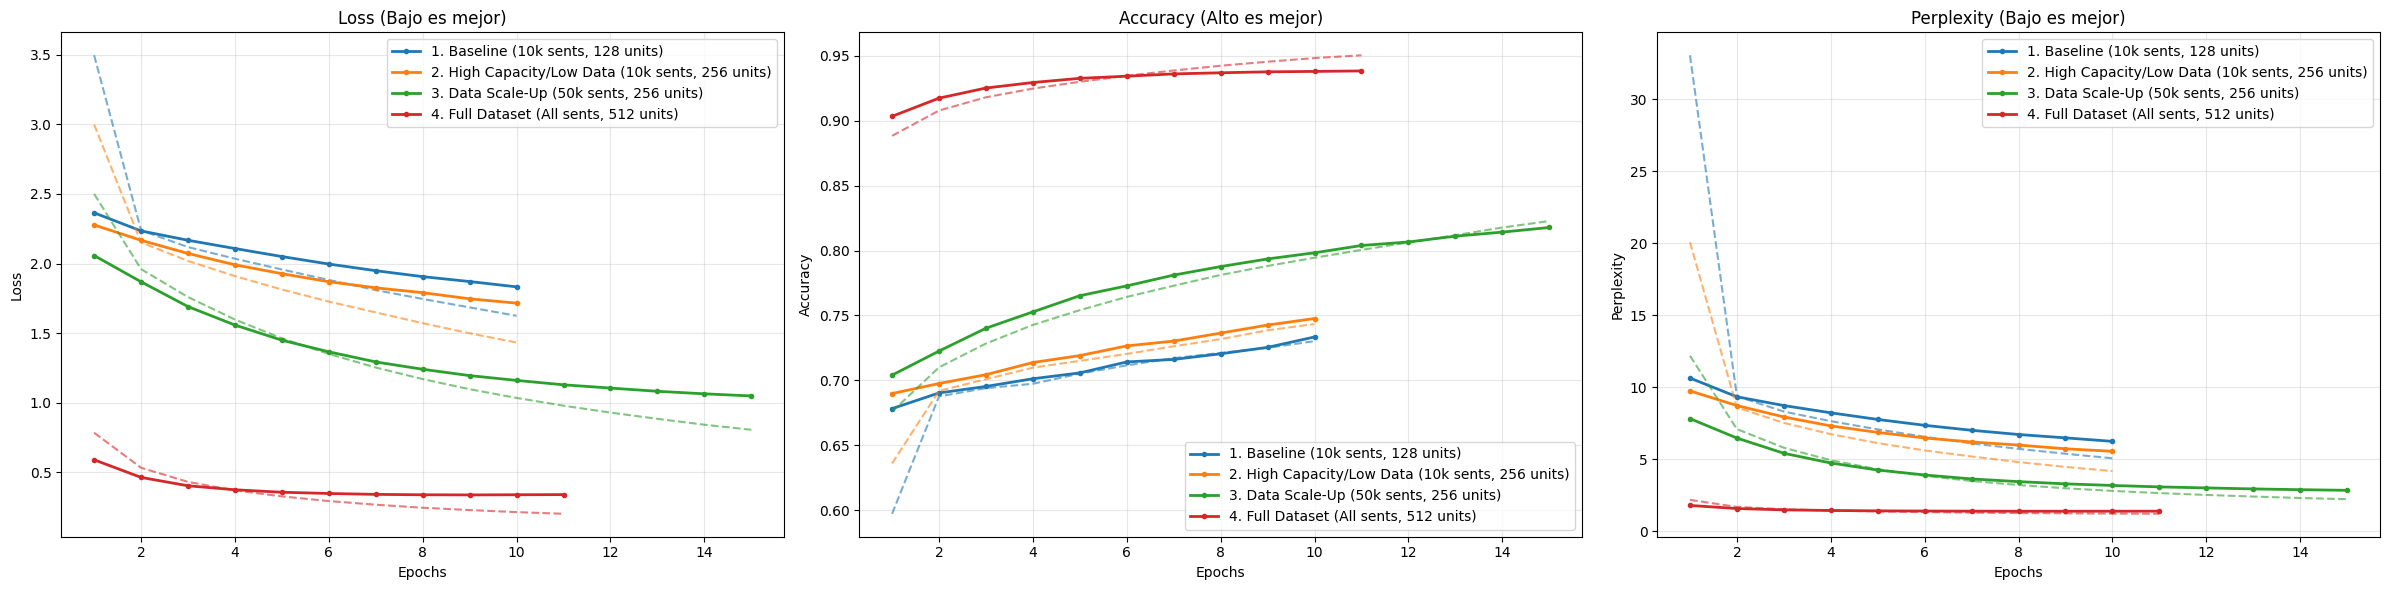

In [14]:
def plot_comparative_results(results_dict):

    plt.figure(figsize=(24, 6))

    metrics_map = [
        ('loss', 'Loss (Bajo es mejor)', 'Loss'),
        ('accuracy', 'Accuracy (Alto es mejor)', 'Accuracy'),
        ('perplexity', 'Perplexity (Bajo es mejor)', 'Perplexity')
    ]

    for idx, (metric, title, ylabel) in enumerate(metrics_map):
        plt.subplot(1, 3, idx + 1)
        
        for name, res in results_dict.items():
            hist = res['history'].history
            epochs = range(1, len(hist['loss']) + 1)
            
            if metric == 'perplexity':
                train_data = hist.get('perplexity', np.exp(hist['loss']))
            else:
                train_data = hist[metric]
            
            val_metric = f"val_{metric}"
            if metric == 'perplexity':
                val_data = hist.get('val_perplexity', np.exp(hist['val_loss']))
            else:
                val_data = hist[val_metric]

            line = plt.plot(epochs, train_data, linestyle='--', marker='', alpha=0.6, linewidth=1.5)
            color = line[0].get_color() 
            
            plt.plot(epochs, val_data, label=f"{name}", 
                     linestyle='-', marker='o', markersize=3, linewidth=2, color=color)

        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        
        plt.legend() 
        plt.grid(True, alpha=0.3)
    
    print("Nota: Líneas Punteadas (---) = Entrenamiento | Líneas Sólidas (___) = Validación")
    plt.tight_layout()
    plt.show()

# Ejecutar la gráfica
if 'results' in locals() and results:
    plot_comparative_results(results)
else:
    print("No hay resultados para graficar.")

In [25]:
def compare_translations(results_dict, text_input=None):

    # Si no se da texto, elegimos uno al azar del primer modelo
    first_res = list(results_dict.values())[0]
    if text_input is None:
        import random
        # Usamos los datos crudos guardados en el resultado
        input_data = first_res['input_data']
        tokenizer = first_res['tokenizer_input']
        
        idx = random.randint(0, len(input_data)-1)
        # Reconstruir texto desde tokens (puede variar un poco del original por el padding)
        # Nota: sequence_to_text devuelve string
        seq = input_data[idx]
        # Eliminamos padding (0) para visualizar
        seq_no_pad = [x for x in seq if x != 0]
        text_input = tokenizer.sequences_to_texts([seq_no_pad])[0]

    print(f"Frase de entrada (Inglés): '{text_input}'\n")

    for name, res in results_dict.items():
        translator = res['translator']
        tokenizer = res['tokenizer_input']
        cfg_used = res['config']
        
        # Preprocesar para este modelo específico (cada modelo tiene su tokenizer propio si cambiamos vocab size)
        seq = tokenizer.texts_to_sequences([text_input])
        padded_seq = pad_sequences(seq, maxlen=cfg_used.MAX_INPUT_LEN)
        
        # Traducir
        decoded = translator.translate_sentence(padded_seq)
        print(f"Model [{name}]:\n -> {decoded}")
        print("-" * 40)

# Probar con una frase aleatoria del set
compare_translations(results)

Frase de entrada (Inglés): 'he plays soccer'

Model [1. Baseline (10k sents, 128 units)]:
 -> él se gusta
----------------------------------------
Model [2. High Capacity/Low Data (10k sents, 256 units)]:
 -> él se quedó
----------------------------------------
Model [3. Data Scale-Up (50k sents, 256 units)]:
 -> él juega tenis
----------------------------------------
Model [4. Full Dataset (All sents, 512 units)]:
 -> juega al fútbol
----------------------------------------


--- 
## Conclusion - TODO